In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 100
rho0 = 20
ens_size = int(20)
obs_size = int(1e3)
rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)

In [6]:
H = np.eye(dimension)[::2]
y_size = H.shape[0]
R = np.eye(y_size)
R_inv = R.copy()
R_sqrt = R.copy()
R_inv_sqrt = R.copy()

In [7]:
eig_val, eig_vec, P = covariance.generate_circulant(
    rho, rho0, covariance.correlation_exp,
    return_Corr = True)
P = P.real

Log10(condition):  3.204300912305241


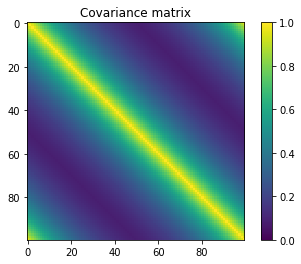

In [8]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

In [9]:
P_sqrt = covariance.matrix_sqrt(eig_val=eig_val,
                                eig_vec=eig_vec)
P_sqrt = P_sqrt.real

In [10]:
P_inv_sqrt = covariance.matrix_sqrt_inv(
    eig_val=eig_val,
    eig_vec=eig_vec)
P_inv_sqrt = P_inv_sqrt.real

In [11]:
mu = np.zeros(dimension)
X_ens = assimilate.generate_ensemble(
    ens_size, mu, P_sqrt)

ground_truth = assimilate.generate_ensemble(
    1, mu, P_sqrt)
# y_ens = y_ens.ravel()
Y_ens = H @ ground_truth + R_sqrt @ np.random.randn(y_size, obs_size)

In [12]:
U, S, VT = sp.linalg.svd(R_inv_sqrt @ H @ P_sqrt)
S = np.diag(S)
S = np.concatenate([S, np.zeros([y_size, dimension - y_size])], axis=1)

In [13]:
X_ens_p = VT @ P_inv_sqrt @ X_ens
Y_ens_p = U.T @ R_inv_sqrt @ Y_ens

In [14]:
def plots_t(P_sqrt, S, VT, P_inv_sqrt, truth, X_ens, rmse, rmse_t,
          y=None, ii=-1):
    plt.figure()
    plt.plot(S @ VT @ P_inv_sqrt @ ground_truth, '--')
    plt.plot(S @ X_ens.mean(axis=1), '-')
    if y is not None:
        plt.scatter(np.arange(y_size), y, marker='.')
    plt.legend(['S @ x\'', 'S @ x\' ens mean', 'y\''])
    plt.title(f'In transformed space: {ii + 1}; rmse: {rmse_t:0.5}')


    plt.figure()
    plt.plot(ground_truth, '--')
    plt.plot(P_sqrt @ VT.T @ X_ens.mean(axis=1), '-')
    if y is not None:
        plt.scatter(np.arange(dimension)[::2], R_sqrt @ U @ y, marker='.')
    plt.legend(['x', 'x ens mean', 'y'])
    plt.title(f'In real space: {ii + 1}; rmse: {rmse:0.5}')

# transformed KF

It took:  0.008870065212249756


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

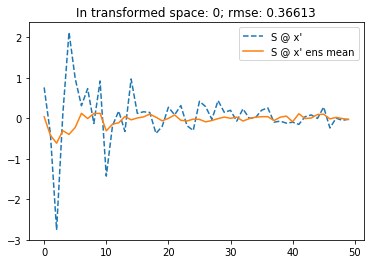

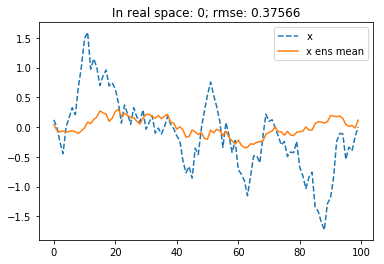

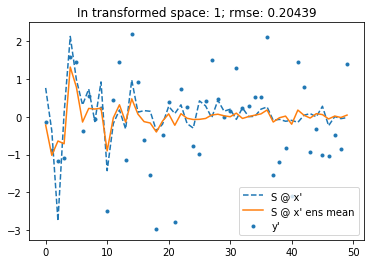

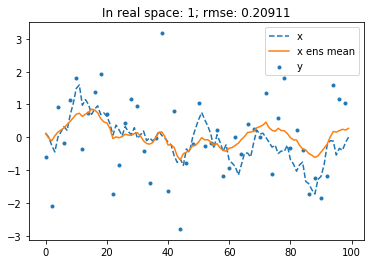

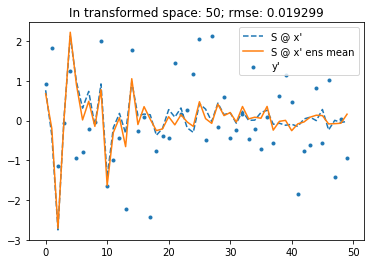

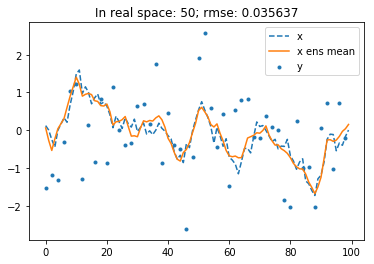

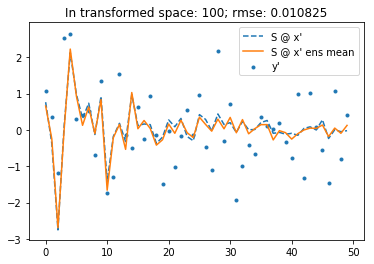

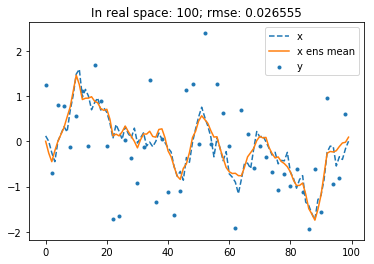

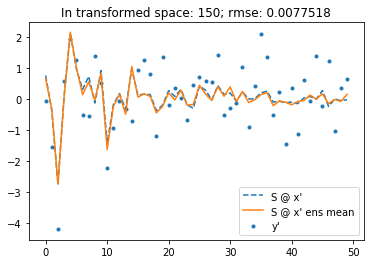

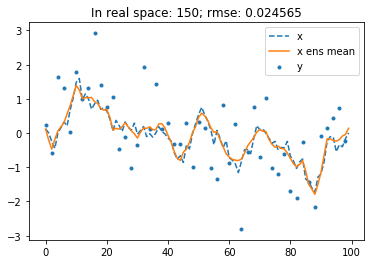

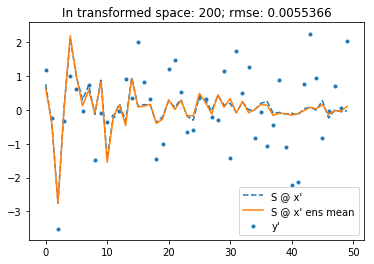

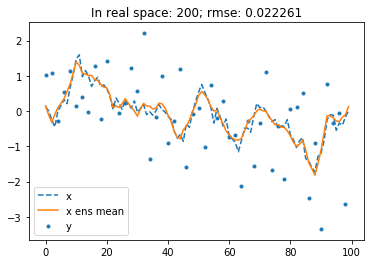

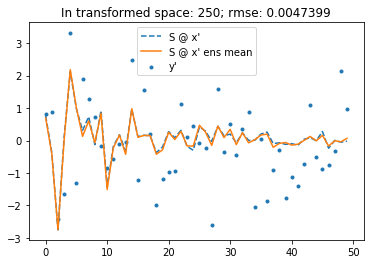

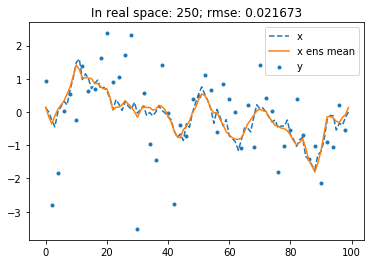

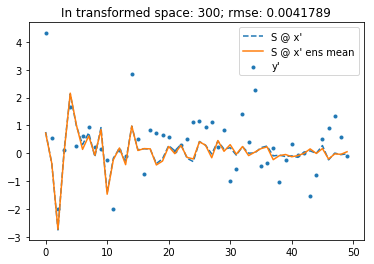

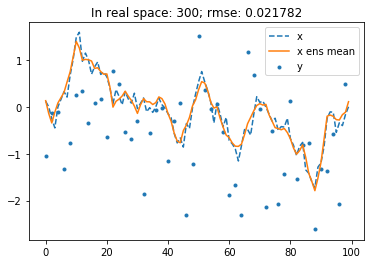

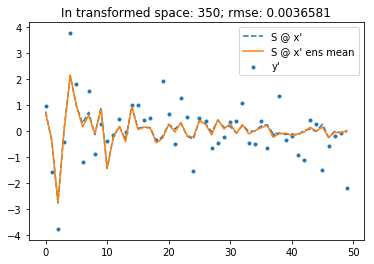

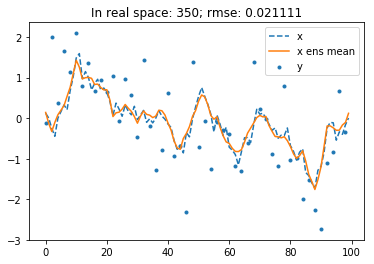

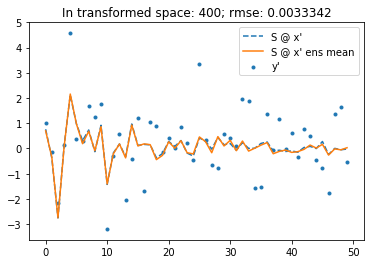

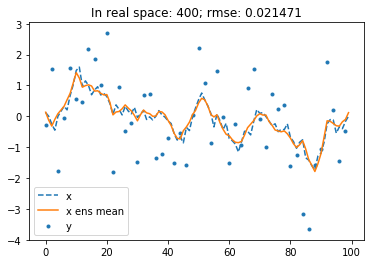

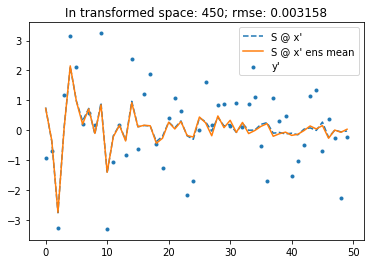

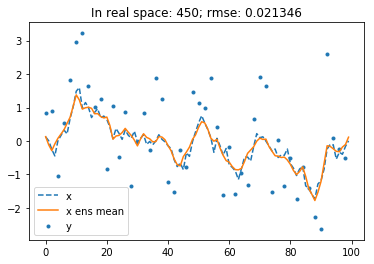

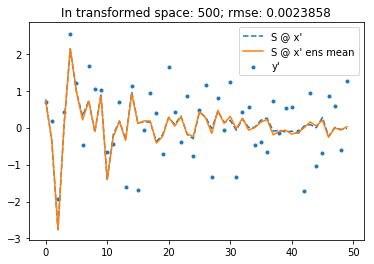

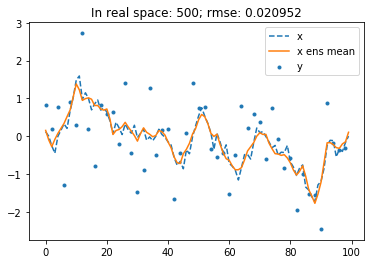

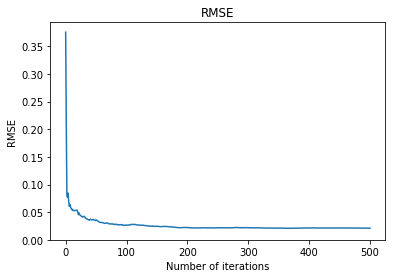

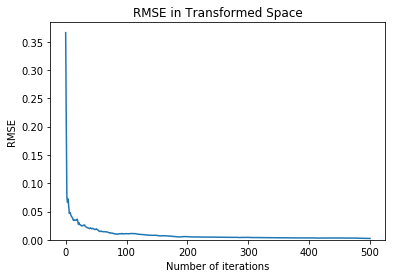

In [15]:
X_ens_kf = X_ens_p.copy()
P_sqrt_kf = P_sqrt.copy()
P_inv_sqrt_kf = P_inv_sqrt.copy()
U_kf = U.copy()
S_kf = S.copy()
S_kf_reduced = S_kf.diagonal()[:, None]
VT_kf = VT.copy()
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()
error = (ground_truth
         - P_sqrt_kf @ VT_kf.T @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S_kf @ VT_kf @ P_inv_sqrt_kf @ ground_truth
           - S_kf @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(P_sqrt_kf, S_kf, VT_kf, P_inv_sqrt_kf,
      ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    # mu_p = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens_p[:, ii][:, None] 
             + U_kf.T @ np.random.randn(y_size, ens_size))
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S_kf @ X_ens_kf))
    error = (ground_truth
             - P_sqrt_kf @ VT_kf.T @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S_kf @ VT_kf @ P_inv_sqrt_kf @ ground_truth
               - S_kf @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(P_sqrt_kf, S_kf, VT_kf, P_inv_sqrt_kf,
              ground_truth, X_ens_kf, rmse[ii + 1],
              rmse_t[ii + 1], y=Y_ens_p[:, ii], ii=ii)
    P_kf_reduced = (I_reduced
                    - K * S_kf_reduced)*P_kf_reduced
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

In [16]:
def plots(truth, X_ens, rmse,
          y=None, ii=-1):
    
    plt.figure()
    plt.plot(ground_truth, '--')
    plt.plot(X_ens.mean(axis=1), '-')
    if y is not None:
        plt.scatter(np.arange(dimension)[::2], y, marker='.')
    plt.legend(['x', 'x ens mean', 'y'])
    plt.title(f'In real space: {ii + 1}; rmse: {rmse:0.5}')

# Standard KF

It took:  0.008667620023091634


Text(0,0.5,'RMSE')

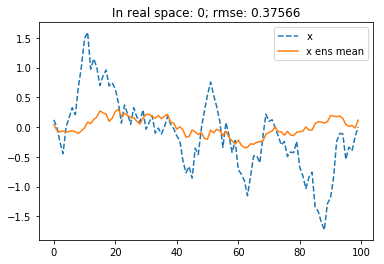

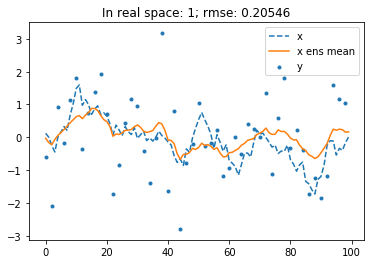

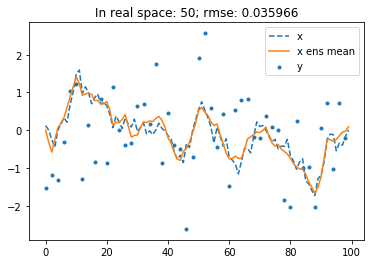

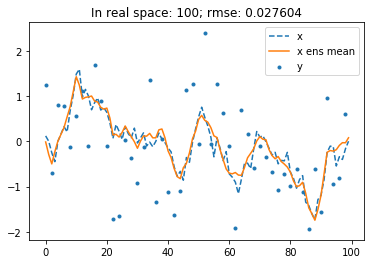

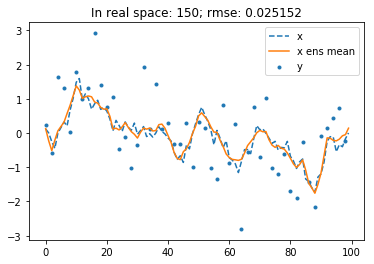

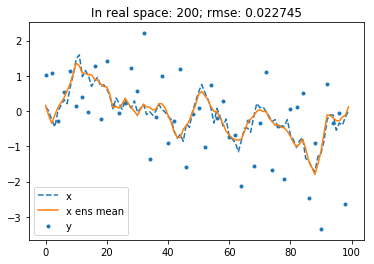

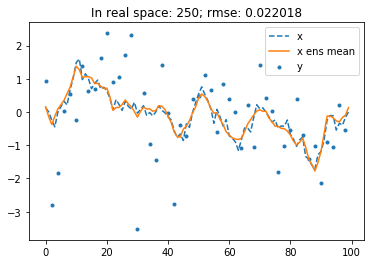

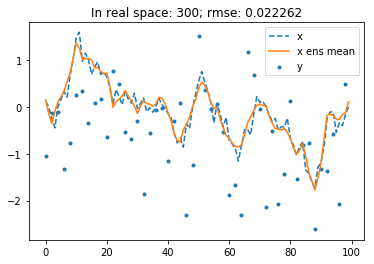

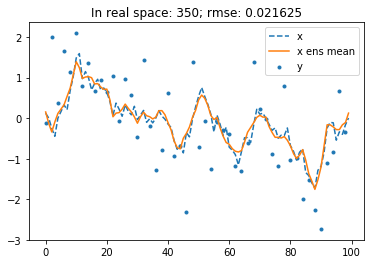

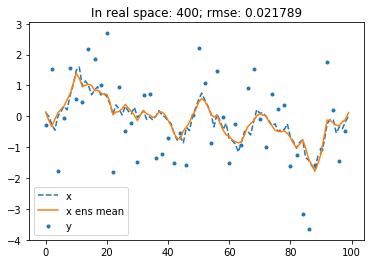

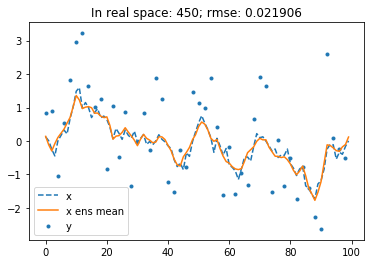

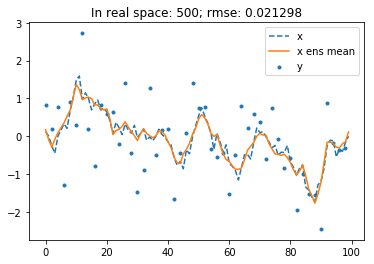

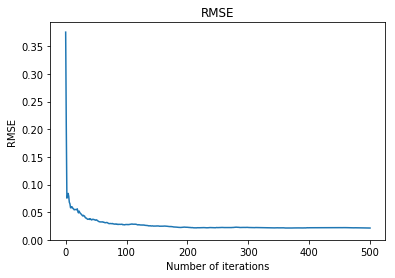

In [17]:
X_ens_kf = X_ens.copy()
P_kf = P.copy()

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
error = (ground_truth
         - X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()

plots(ground_truth, X_ens_kf, rmse[0])
time0 = time.time()
for ii in range(iterations):
    mu = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens[:, ii][:, None] 
             + R_sqrt @ np.random.randn(y_size, ens_size))
    K = (P_kf @ H.T
         @ sp.linalg.inv(
             R + H @ P_kf @ H.T))
    X_ens_kf = X_ens_kf + K @ (Y_obs - H @ X_ens_kf)
    error = (ground_truth
             - X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots(ground_truth, X_ens_kf, rmse[ii + 1],
              y=Y_ens[:, ii], ii=ii)
    P_kf = (np.eye(dimension) - K @ H) @ P_kf
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)

plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

# transformed EnKF

It took:  0.010334932804107666


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

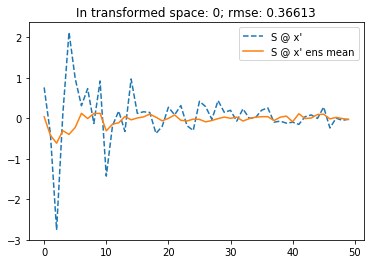

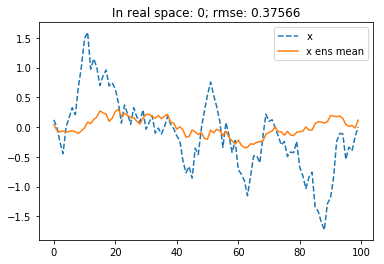

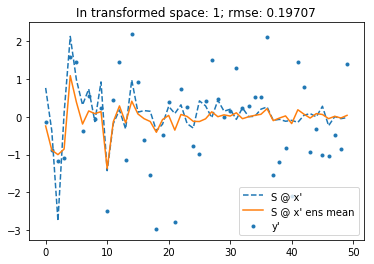

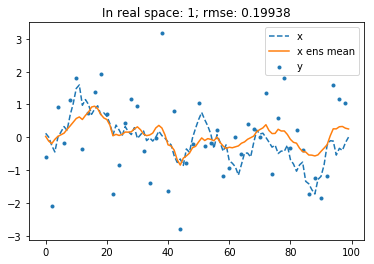

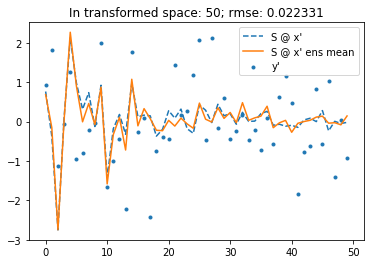

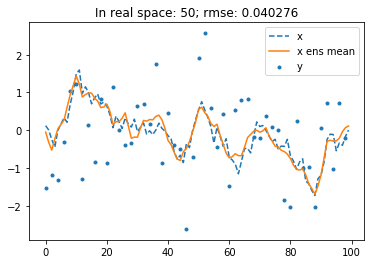

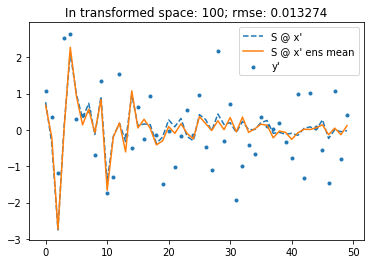

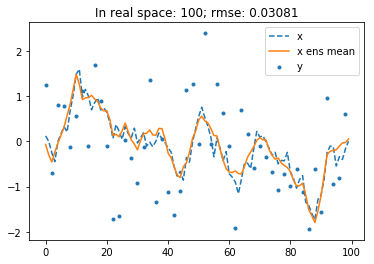

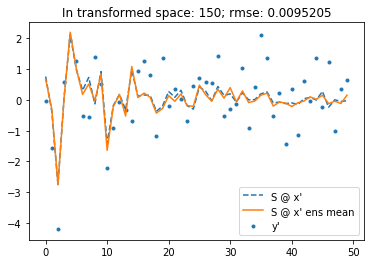

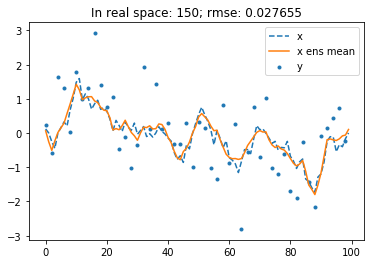

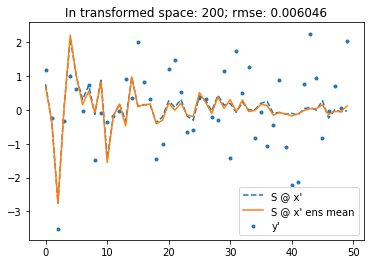

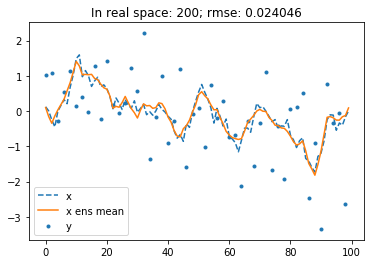

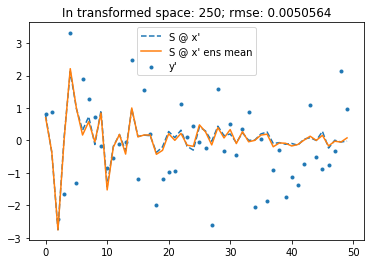

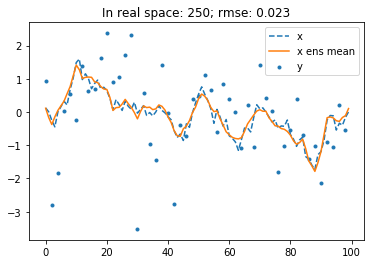

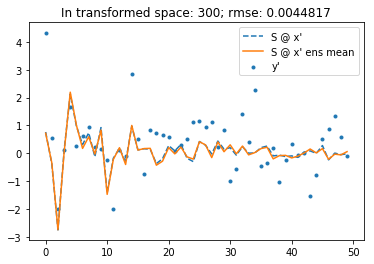

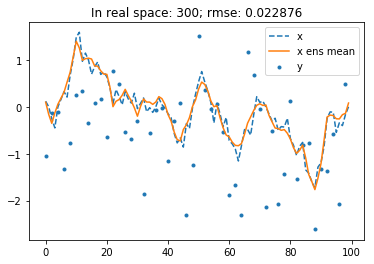

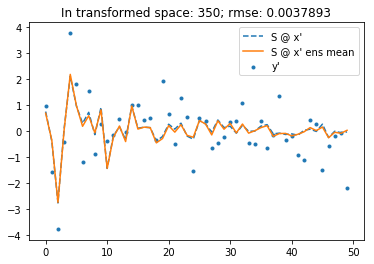

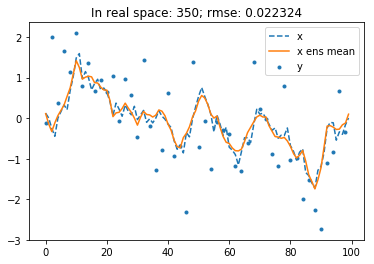

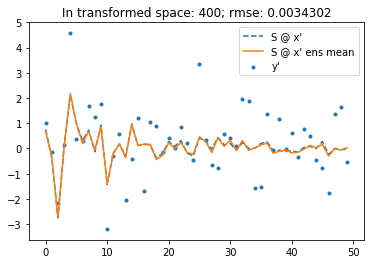

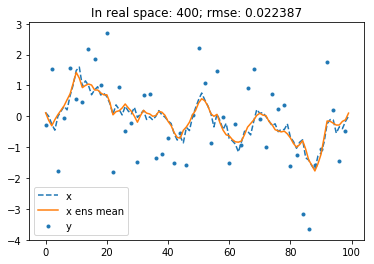

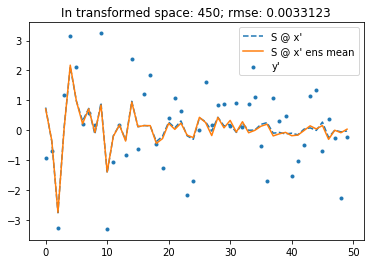

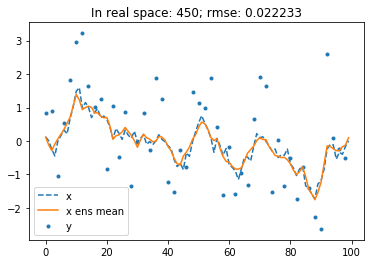

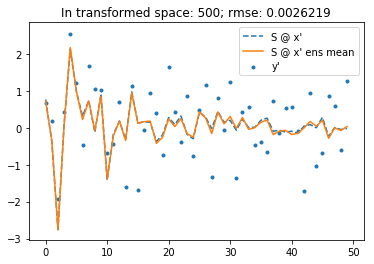

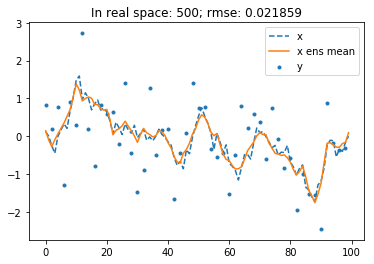

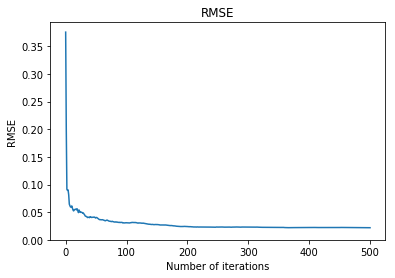

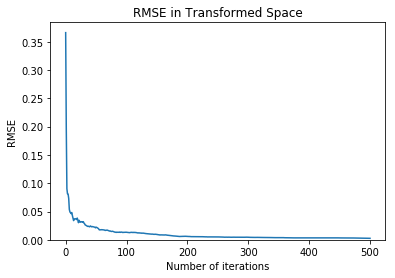

In [18]:
X_ens_kf = X_ens_p.copy()
P_sqrt_kf = P_sqrt.copy()
P_inv_sqrt_kf = P_inv_sqrt.copy()
U_kf = U.copy()
S_kf = S.copy()
S_kf_reduced = S_kf.diagonal()[:, None]
VT_kf = VT.copy()
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()
error = (ground_truth
         - P_sqrt_kf @ VT_kf.T @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S_kf @ VT_kf @ P_inv_sqrt_kf @ ground_truth
           - S_kf @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(P_sqrt_kf, S_kf, VT_kf, P_inv_sqrt_kf,
      ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    # mu_p = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens_p[:, ii][:, None] 
             + U_kf.T @ np.random.randn(y_size, ens_size))
    P_kf_reduced = np.var(X_ens_kf[:y_size], axis=1)[:, None]
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S_kf @ X_ens_kf))
    error = (ground_truth
             - P_sqrt_kf @ VT_kf.T @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S_kf @ VT_kf @ P_inv_sqrt_kf @ ground_truth
               - S_kf @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(P_sqrt_kf, S_kf, VT_kf, P_inv_sqrt_kf,
              ground_truth, X_ens_kf, rmse[ii + 1],
              rmse_t[ii + 1], y=Y_ens_p[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

# Standard EnKF (No loc)

It took:  0.00942138433456421 

Number of ensemble members:  20 



Text(0,0.5,'RMSE')

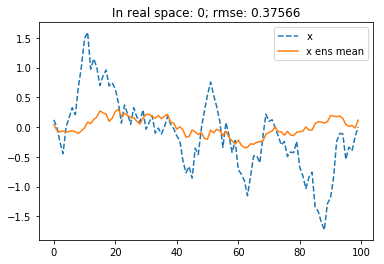

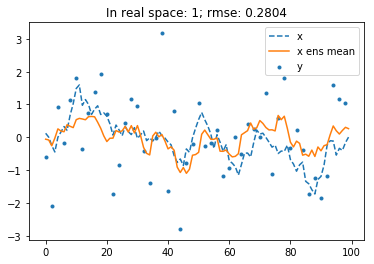

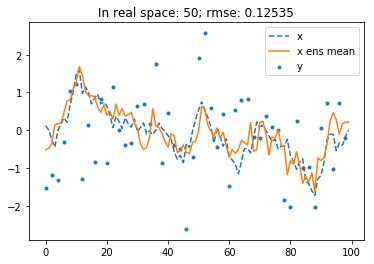

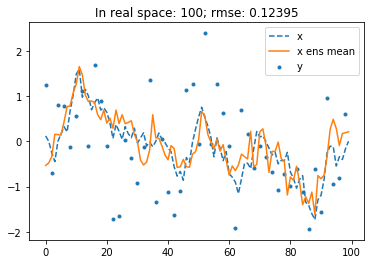

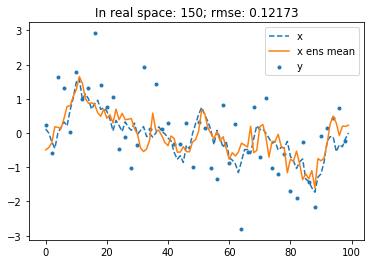

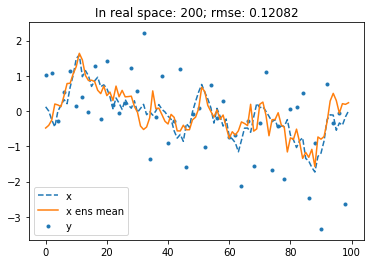

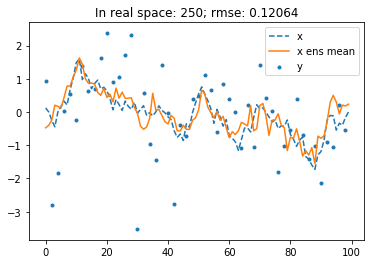

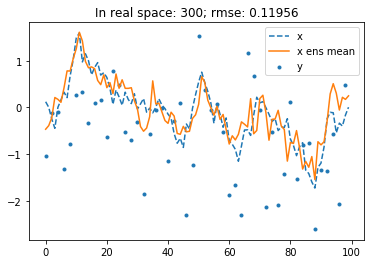

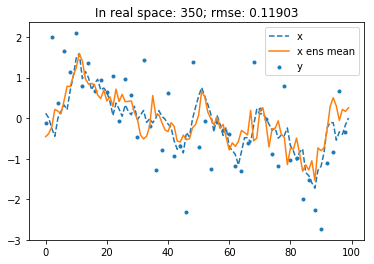

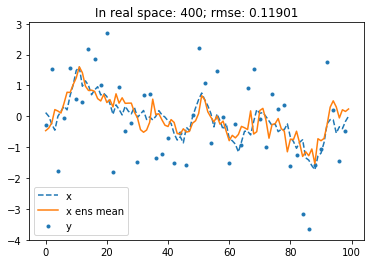

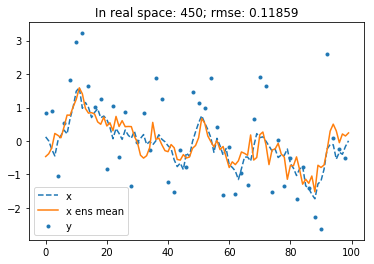

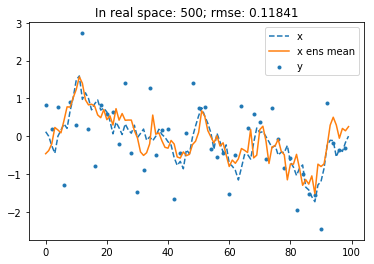

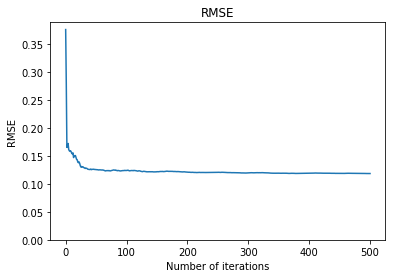

In [19]:
X_ens_kf = X_ens.copy()
P_kf = P.copy()

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
error = (ground_truth
         - X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()

plots(ground_truth, X_ens_kf, rmse[0])
time0 = time.time()
for ii in range(iterations):
    mu = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens[:, ii][:, None] 
             + R_sqrt @ np.random.randn(y_size, ens_size))
    P_kf = np.cov(X_ens_kf)
    K = (P_kf @ H.T
         @ sp.linalg.inv(
             R + H @ P_kf @ H.T))
    X_ens_kf = X_ens_kf + K @ (Y_obs - H @ X_ens_kf)
    error = (ground_truth
             - X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots(ground_truth, X_ens_kf, rmse[ii + 1],
              y=Y_ens[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed, '\n')
print('Number of ensemble members: ', ens_size, '\n')

plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

# With P approximation

In [20]:
eig_num = 20
P_ens = (eig_vec[:, :eig_num]  @ np.diag(eig_val[:eig_num])
         @ eig_vec[:, :eig_num].conj().T).real
returned = covariance.matrix_sqrt(C=P_ens, return_eig=True)
P_sqrt_ens, eig_val_ens, eig_vec_ens = returned
P_sqrt_ens = P_sqrt_ens.real
P_inv_sqrt_ens = covariance.matrix_sqrt_inv(
    eig_val=eig_val_ens,
    eig_vec=eig_vec_ens)
P_inv_sqrt_ens = P_inv_sqrt_ens.real
U_ens, S_ens, VT_ens = sp.linalg.svd(R_inv_sqrt @ H @ P_sqrt_ens)
S_ens = np.diag(S_ens)
S_ens = np.concatenate(
    [S_ens, np.zeros([y_size, dimension - y_size])], axis=1)
X_ens_p2 = VT_ens @ P_inv_sqrt_ens @ X_ens
Y_ens_p2 = U_ens.T @ R_inv_sqrt @ Y_ens

It took:  0.009573082129160563 

Number of eigenvalues:  20 

Number of ensemble members:  20 



/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

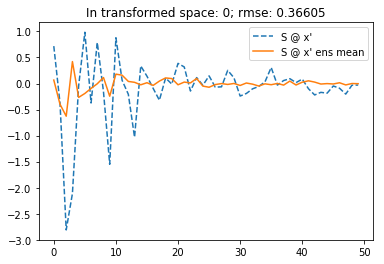

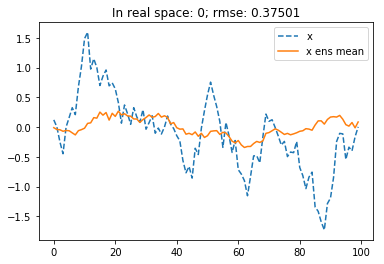

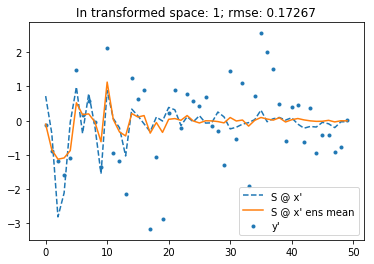

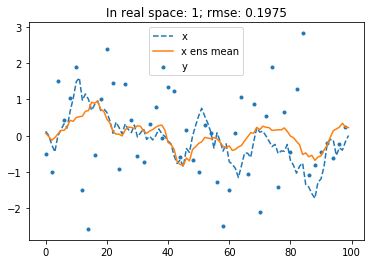

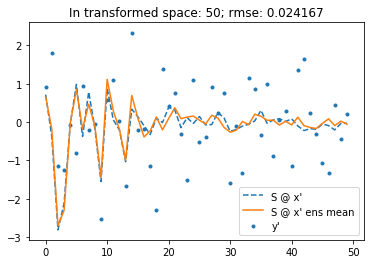

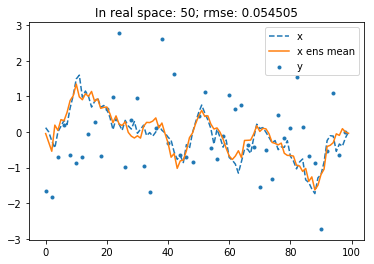

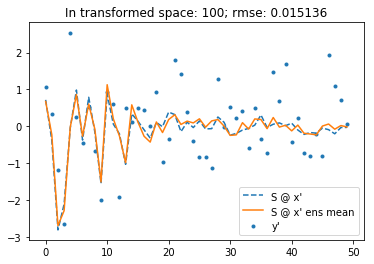

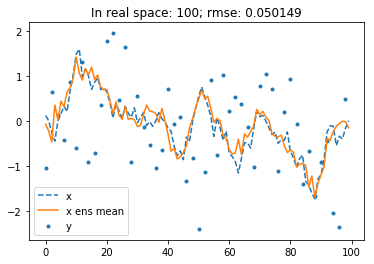

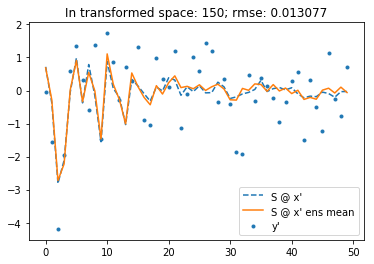

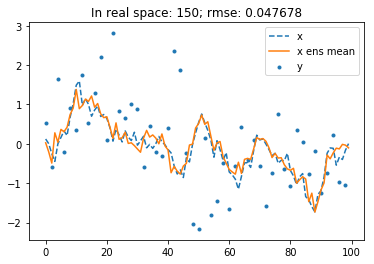

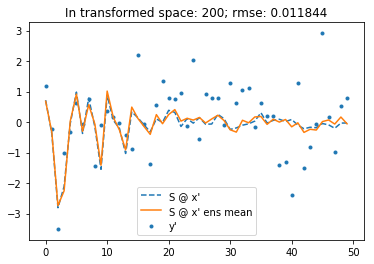

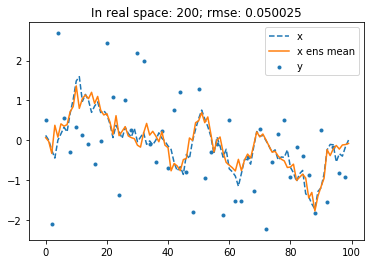

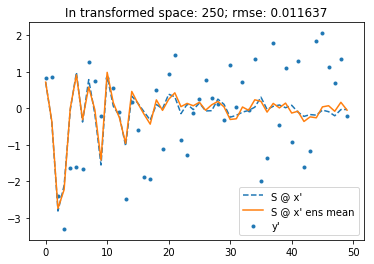

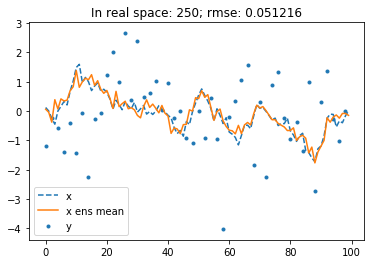

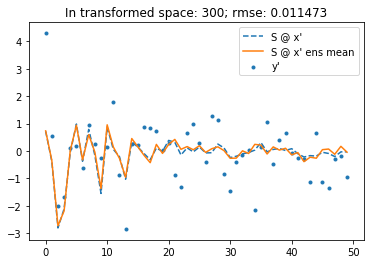

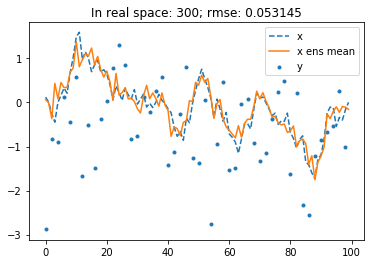

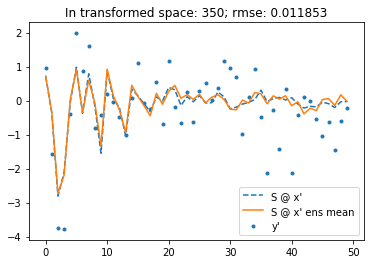

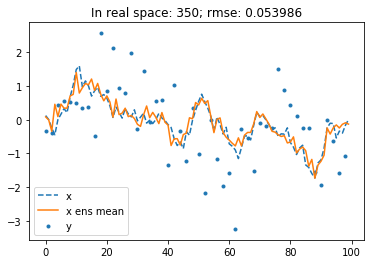

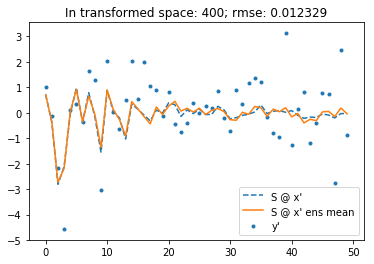

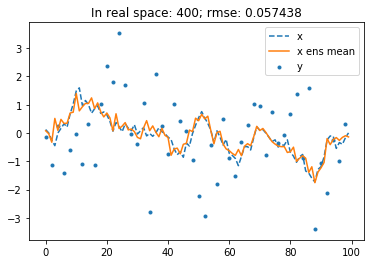

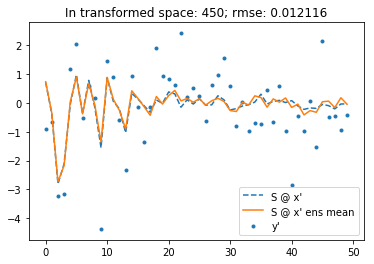

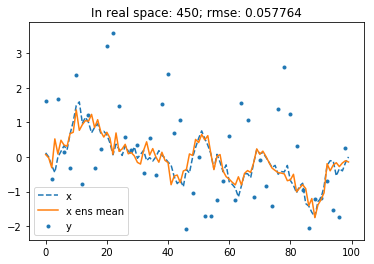

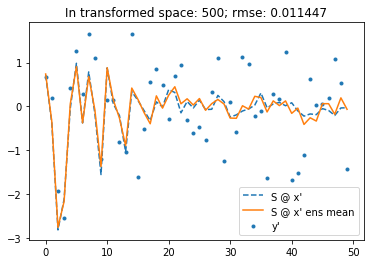

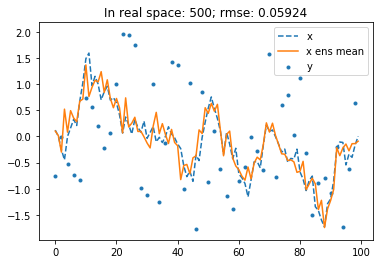

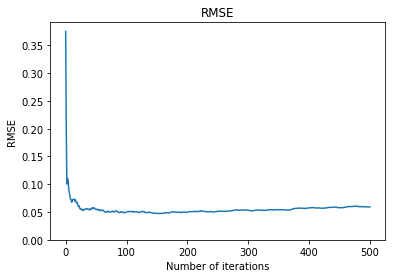

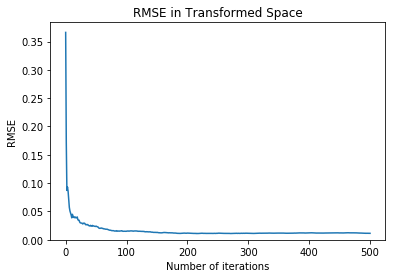

In [21]:
X_ens_kf = X_ens_p2.copy()
Y_ens_kf = Y_ens_p2.copy()
P_sqrt_kf = P_sqrt_ens.copy()
P_inv_sqrt_kf = P_inv_sqrt_ens.copy()
U_kf = U_ens.copy()
S_kf = S_ens.copy()
VT_kf = VT_ens.copy()
S_kf_reduced = S_kf.diagonal()[:, None]
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()
error = (ground_truth
         - P_sqrt_kf @ VT_kf.T @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S_kf @ VT_kf @ P_inv_sqrt_kf @ ground_truth
           - S_kf @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(P_sqrt_kf, S_kf, VT_kf, P_inv_sqrt_kf,
      ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    # mu_p = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens_kf[:, ii][:, None] 
             + U_kf.T @ np.random.randn(y_size, ens_size))
    P_kf_reduced = np.var(X_ens_kf[:y_size], axis=1)[:, None]
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S_kf @ X_ens_kf))
    error = (ground_truth
             - P_sqrt_kf @ VT_kf.T @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S_kf @ VT_kf @ P_inv_sqrt_kf @ ground_truth
               - S_kf @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(P_sqrt_kf, S_kf, VT_kf, P_inv_sqrt_kf,
              ground_truth, X_ens_kf, rmse[ii + 1],
              rmse_t[ii + 1], y=Y_ens_kf[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed, '\n')
print('Number of eigenvalues: ', eig_num, '\n')
print('Number of ensemble members: ', ens_size, '\n')
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')